In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cluster'

In [2]:
### --- UNPACK RESULTS --- ###

file_name = 'Fig_1_2_RFLO_Anecdote_Result'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/Paper_Submission'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)
signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                             'n_nodes': get_checkpoint_n_stable_FPs},
                                results_subdir='Paper_Submission')

In [3]:
### --- ASSIGN TO STAGES --- ###

loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
performance_criterion = 0.05
topological_criterion = 0.02
loss_window = 1
topological_window = 30
stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                      performance_criterion=performance_criterion,
                                                                      topological_criterion=topological_criterion,
                                                                      loss_window=loss_window,
                                                                      topological_window=topological_window)

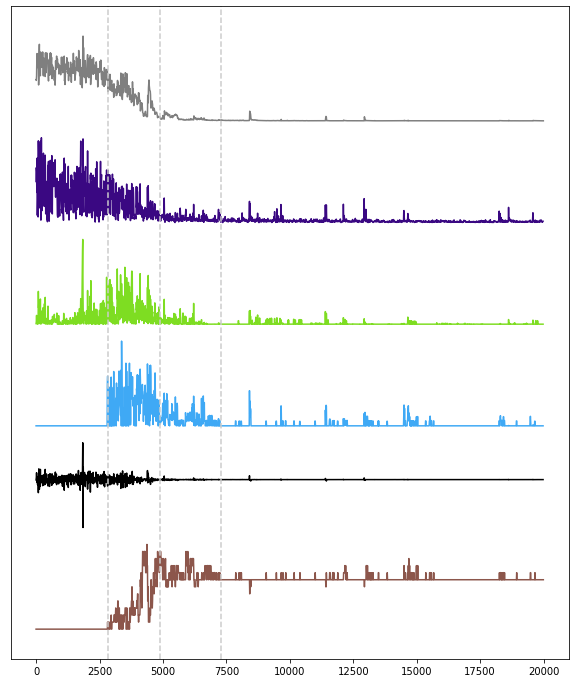

In [4]:
### --- GENERATE FIGURE 1C TRACES --- ###

signals['d_loss'] = signals['test_loss'][1:] - signals['test_loss'][:-1]
fig = plot_signals(signals, x_values=indices, signal_clips={'test_loss': 1.2}, legend=False,
                   key_restriction=['test_loss', 'rec_weight_distances',
                                    'CKA_distances', 'aligned_graph_distances', 'd_loss',
                                    'n_nodes'],
                   colors=['#7F7F7F', '#3A0882', '#7EDD22', '#3FA9F5', 'k', '#8C564B'])
for t in t_stage_transitions:
    plt.axvline(x=t*10, linestyle='--', color=('0.8'))
#fig.savefig('figs/fig1c_traces.pdf', format='pdf')

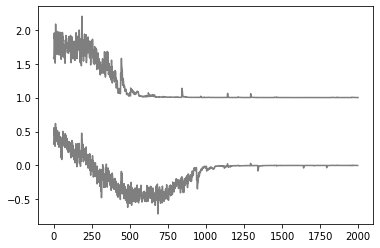

In [22]:
plt.figure()
n_kernel = 500
y = signals['test_loss'].copy()
y_clipped = np.clip(y, 0, 1.2)
y = np.concatenate([y_clipped[n_kernel-1:0:-1], y_clipped])
y = np.convolve(y, np.ones(n_kernel)/n_kernel, mode='valid')[:-1]
d_loss = y[1:] - y[:-1]
#plt.plot(np.convolve(d_loss, np.ones(100) / 100, mode='valid'))
plt.plot(300*d_loss, color='#7F7F7F')
plt.plot(y_clipped + 1, color='#7F7F7F')

In [16]:
### --- GENERATE MOVIE FRAMES --- ###

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
np.random.seed(8)
data = task.gen_data(100, 100)
for i_checkpoint in range(0, 20000, 10):
    if i_checkpoint > 0:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
        checkpoint_1 = checkpoints['checkpoint_{}'.format(i_checkpoint - 10)]
        align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
    else:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
    
    fig = plot_input_dependent_topology(checkpoint_2, data, space_range=0.5,
                                        colors_=colors, color_scheme='different',
                                        return_fig=True, output_ylim=[-8.3, 3.2])
    fig.savefig('figs/movie_stack/cp_{}.jpg'.format(i_checkpoint), dpi=200, format='jpg')
    plt.close(fig)

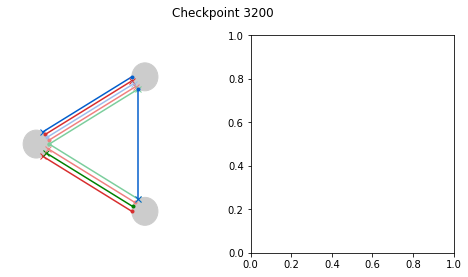

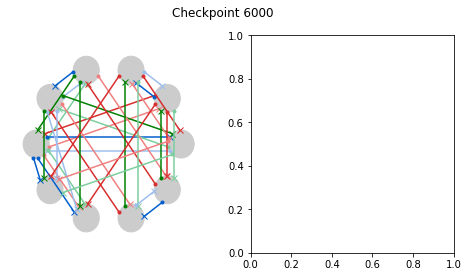

In [17]:
### --- GENERATE FIG 1C SNAPSHOTS --- ###

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
np.random.seed(8)
data = task.gen_data(100, 100)
for i_checkpoint in [3200, 6000]:
    if i_checkpoint > 0:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
        checkpoint_1 = checkpoints['checkpoint_{}'.format(i_checkpoint - 10)]
        align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
    else:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
    
    fig = plot_input_dependent_topology(checkpoint_2, data, space_range=0.5,
                                        colors_=colors, color_scheme='different',
                                        plot_output=False,
                                        return_fig=True, output_ylim=[-8.3, 3.2])
    fig.savefig('figs/cp_ex_{}.pdf'.format(i_checkpoint), dpi=200, format='pdf')

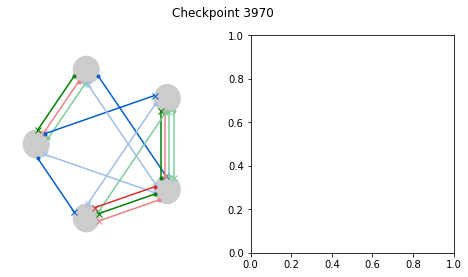

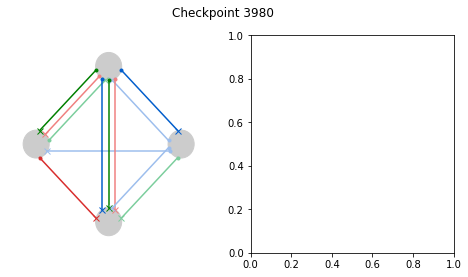

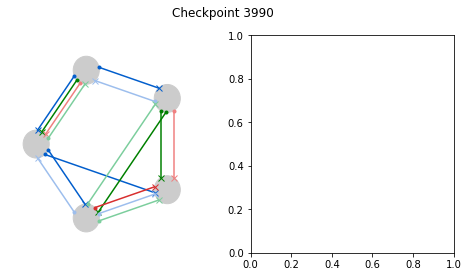

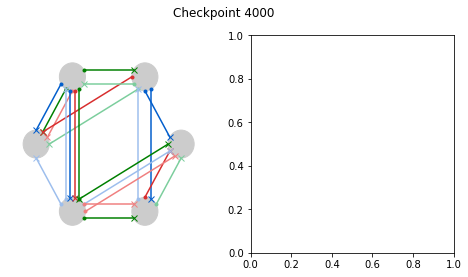

In [18]:
### --- GENERATE FIG 2B SNAPSHOTS --- ###

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
np.random.seed(8)
data = task.gen_data(100, 100)
for i_checkpoint in range(3970, 4010, 10):
    if i_checkpoint > 0:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
        checkpoint_1 = checkpoints['checkpoint_{}'.format(i_checkpoint - 10)]
        align_checkpoints_based_on_output(checkpoint_2, checkpoint_1)
    else:
        checkpoint_2 = checkpoints['checkpoint_{}'.format(i_checkpoint)]
    
    fig = plot_input_dependent_topology(checkpoint_2, data, space_range=0.5,
                                        colors_=colors, color_scheme='different',
                                        plot_output=False,
                                        return_fig=True, output_ylim=[-8.3, 3.2])
    fig.savefig('figs/cp_ex_{}.pdf'.format(i_checkpoint), dpi=200, format='pdf')

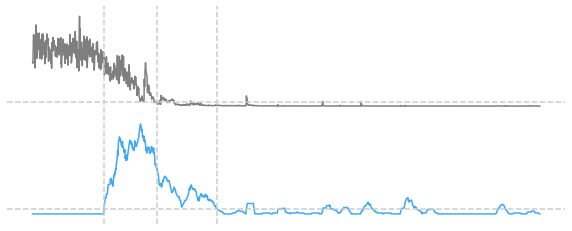

In [20]:
### --- GENERATE FIG 2A FILTERED TRACES --- ###

loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
convolved_loss, convolved_d_top = filter_loss_and_dtop(loss, d_top,
                                                       loss_window=loss_window,
                                                       topological_window=topological_window)
signals['convolved_loss'] = convolved_loss
signals['convolved_d_top'] = convolved_d_top
loss_max = np.amax(convolved_loss)
loss_max = 1.2
loss_min = np.amin(convolved_loss)
pc_scaled = (performance_criterion - loss_min) / (loss_max - loss_min)
top_max = np.amax(convolved_d_top)
top_min = np.amin(convolved_d_top)
tc_scaled = (topological_criterion - top_min) / (top_max - top_min)
fig = plot_signals(signals, x_values=indices, signal_clips={'convolved_loss': 1.2}, legend=False,
                   key_restriction=['convolved_loss', 'convolved_d_top'],
                   colors=['#7F7F7F', '#3FA9F5'])
for t in t_stage_transitions:
    plt.axvline(x=t*10, linestyle='--', color=('0.8'))
plt.axhline(y=pc_scaled, linestyle='--', color=('0.8'))
plt.axhline(y=tc_scaled - 1.2, linestyle='--', color=('0.8'))
plt.axis('off')
#fig.savefig('figs/fig2a_traces.pdf', format='pdf')